# Import Packages

In [375]:
import pandas as pd
import numpy as np
import pickle
import matplotlib.pyplot as plt
import re
import time
import matplotlib.pyplot as plt
%matplotlib inline

from langdetect import detect
from googletrans import Translator

import nltk
# nltk.download('wordnet')
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
import string
from nltk import word_tokenize, FreqDist
from nltk.sentiment.vader import SentimentIntensityAnalyzer

import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text as text
tf.get_logger().setLevel('ERROR')

from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer, TfidfTransformer
from sklearn.metrics import accuracy_score, f1_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.experimental import enable_hist_gradient_boosting
from sklearn.ensemble import RandomForestClassifier, HistGradientBoostingClassifier
from sklearn.naive_bayes import MultinomialNB
from xgboost import XGBClassifier

### Load in Pickeled DataFrame

In [ ]:
tweets = pd.read_pickle('data/pickle_jar/cleaned2.pkl')
denier_sup = pd.read_pickle('data/pickle_jar/denier_sup.pkl')

## Explore Data

In [ ]:
# verify import
tweets.info()

In [ ]:
# look at missing values
tweets.isna().sum()

In [ ]:
denier_sup['date'] = pd.to_datetime(denier_sup['date'])
denier_sup.columns = ['created_at', 'screen_names', 'names', 'full_text', 'retweeted_status', 
                      'hashtags', 'nlikes', 'search']

## Prepare Data for Modeling

First, ground truth must be determined. To do this, hashtags are examined and parsed to find ones that clearly indicate a person's view on climate change. Then all tweets containing those tweets are labeled and prepared for modeling

In [ ]:
# subset data that contains hashtags
df = tweets.dropna(subset=['hashtags'])

In [ ]:
# create a list of all hashtags

hashtags_all = []
for row in df['hashtags']:
    for item in row:
        hashtags_all.append(item.lower())

In [ ]:
# see hashtag count and sort by frequency
unique_hashtags = list(pd.Series(hashtags_all).value_counts().index)
# view top 5 for reference
print(unique_hashtags[:5])

In [ ]:
# most common tags associated with sample of tweets presenting climate denial
denier_tags = ['climatechangeisfalse', 'climatechangenotreal', 'climatechangehoax', 
               'globalwarminghoax', 'tcot', 'ccot', 'tlot', 'pjnet', 'rednationrising', 'votered', 
               'libtard', 'libtards', 'maga']

# most common tags associated with sample of tweets indicating belief in climate science
believer_tags = ['climatechangeisreal', 'actonclimate', 'extinctionrebellion', 'climateemergency', 
                 'climateactionnow', 'capitalism', 'public_health', 'climateaction', 'humanityextinction',
                 'activism', 'noplanetb', 'savetheplanet']

In [ ]:
# assign believer status to each row in the dataset
believe_series = []
for idx, row in df['hashtags'].iteritems():
    # set a count for matching tags in row
    believe = 0
    deny = 0 
    for tag in row:
        if tag.lower() in denier_tags:
            deny += 1
        elif tag.lower() in believer_tags:
            believe += 1
    
    # check that only one type of tag appears
    if (believe > 0) and (deny == 0):
        believe_series.append(1)
    elif (believe == 0) and (deny > 0):
        believe_series.append(0)
    else: # <-- if no matching tag OR if both appear, label as unknown using nonetype 
        believe_series.append(None)

### Add believer status to DataFrame

In [ ]:
df = df.assign(believer = believe_series)

In [ ]:
denier_sup['believer'] = 0

In [247]:
# subset dataframe to only include positive and negative cases
to_train = df.dropna(subset=['believer'])

### Create function to prep text for NLP processing

Remove unwanted character types, hashtags, usernames, and URLs. Remove line breaks and extra spaces

Tokenize, remove stopwords, lemmatize, join to string

In [250]:
def re_clean(tweet):
    # regex cleaning
    tweet = tweet.lower()
    tweet = re.sub(r'[@][\w]+','', tweet) # <-- remove usernames
    tweet = re.sub(r'[#]','', tweet) # <-- remove hashtags 
    tweet = re.sub(r'http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+', '', tweet) # <-- remove urls
    tweet = re.sub(r'\s{2,15}', ' ', tweet) # <-- remove extra blank spaces
    tweet = re.sub(r'\n', ' ', tweet)  # <-- remove line breaks
    tweet = re.sub(r'\s{2,15}', ' ', tweet) # <-- combine multiple space again 
    return tweet.strip() # <-- remove extra spaces at the start and end of tweets

In [251]:
# Instantiate nltk lemmatizer
lemmatizer = WordNetLemmatizer()

# create stop word list from default list, punctuation, and hashtags used to create classifcation params
stopwords_list = stopwords.words('english') + (list(string.punctuation) + 
                                               denier_tags + believer_tags + unique_hashtags[:100])

def lemm(tweet):    
    # tokenize, lemmatize
    tok = nltk.regexp_tokenize(tweet, r"([a-zA-Z]+(?:'[a-z]+)?)")
    lemma = [lemmatizer.lemmatize(token) for token in tok]
    # return combined string 
    return ' '.join(lemma)

In [252]:
def clean_and_lem(tweet):
    '''
    clean then lammatize tweet
    '''
    return lemm(re_clean(tweet))

In [219]:
def aug_translate(series, lang = 'fr'):
    return translator.translate(list(series.values), lang_tgt=lang)
#     return pd.Series(translator.translate(translations, lang_tgt='en'))


In [121]:
# create function to compare original text to cleaned text 
def check_cleaned(df, n = None):
    if not n:
        n = np.random.randint(0, len(df) - 1)
    print(f"ORIGINAL: \n{df.iloc[n]['full_text']} \n")
    print(f"CLEANED: \n{clean_and_lem(df.iloc[n]['full_text'])}")
    
check_cleaned(to_train)

ORIGINAL: 
If we don’t protect the ocean, humanitarian disaster awaits  https://t.co/IHaHBcRX9Z #actonclimate #sustainability #plastic #ethoslifestyle 

CLEANED: 
if we don t protect the ocean humanitarian disaster awaits actonclimate sustainability plastic ethoslifestyle


### Augment minority class

In [177]:
to_aug = to_train[to_train['believer'] == 0]
to_aug_ser = to_aug['full_text'].apply(lambda x: re_clean(x))

In [202]:
to_aug_ser

112        as america burns from climatechange, trump off...
2442                           maga kag cult45 wakethefuckup
2941       exactly. and obama said the jobs would never c...
3230       trump ineffective &amp; weak➡ nodealconman rea...
3263       climate deniers are the first to shrug off glo...
                                 ...                        
1969173    i happen to be an american with a penis which ...
1969284                                  👍 climatechangehoax
1969495    and nobody is surprised because climate change...
1969674                                                 maga
1970131    under what us president was that report initia...
Name: full_text, Length: 7608, dtype: object

In [193]:
aug = pd.Series(dtype='object')
for lang in ['fr', 'de', 'he', 'ja']:
    aug = aug.append(aug_translate(to_aug_ser, lang))

In [197]:
aug.values[0]

"112 as America burns due to climate change, trump off ... 2442 maga kag cult45 wakethefuckup 2941 exactly. and obama said jobs would never be c ... 3230 inefficient asset & amp; weak➡ nodealconman rea ... 3263 climate deniers are the first to ignore the glo ... ... 1969173 I'm an American with a penis that ... 1969284 👍 climate change 1969495 and no one is surprised because the change climate ... 1969674 maga 1970131 under which US president was this report initiated ... Name: full_text, Length: 7608, dtype: object "

###### Clean Dataset text

In [322]:
X = to_train['full_text'].apply(lambda x: clean_and_lem(x))
X = X.combine_first(denier_sup['full_text'].apply(lambda x: clean_and_lem(x))).reset_index()
X = X.drop(columns='index')['full_text']

In [323]:
# create target variable
y = to_train['believer'].combine_first(denier_sup['believer'])
y = y.reset_index().drop(columns='index')['believer']

# Tensorflow Setup

In [321]:
bert_model_name = 'small_bert/bert_en_uncased_L-4_H-512_A-8' 

map_name_to_handle = {
    'bert_en_uncased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/3',
    'bert_en_cased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_cased_L-12_H-768_A-12/3',
    'bert_multi_cased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_multi_cased_L-12_H-768_A-12/3',
    'small_bert/bert_en_uncased_L-2_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-2_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-2_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-2_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-4_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-4_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-4_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-4_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-6_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-6_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-6_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-6_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-6_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-6_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-6_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-6_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-8_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-8_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-8_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-8_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-10_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-10_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-10_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-10_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-10_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-10_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-10_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-10_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-12_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-12_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-12_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-12_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-12_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-12_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-12_H-768_A-12/1',
    'albert_en_base':
        'https://tfhub.dev/tensorflow/albert_en_base/2',
    'electra_small':
        'https://tfhub.dev/google/electra_small/2',
    'electra_base':
        'https://tfhub.dev/google/electra_base/2',
    'experts_pubmed':
        'https://tfhub.dev/google/experts/bert/pubmed/2',
    'experts_wiki_books':
        'https://tfhub.dev/google/experts/bert/wiki_books/2',
    'talking-heads_base':
        'https://tfhub.dev/tensorflow/talkheads_ggelu_bert_en_base/1',
}

map_model_to_preprocess = {
    'bert_en_uncased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'bert_en_cased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_cased_preprocess/3',
    'small_bert/bert_en_uncased_L-2_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-2_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-2_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-2_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-4_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-4_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-4_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-4_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-6_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-6_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-6_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-6_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-8_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-8_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-8_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-8_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-10_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-10_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-10_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-10_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-12_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-12_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-12_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'bert_multi_cased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_multi_cased_preprocess/3',
    'albert_en_base':
        'https://tfhub.dev/tensorflow/albert_en_preprocess/2',
    'electra_small':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'electra_base':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'experts_pubmed':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'experts_wiki_books':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'talking-heads_base':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
}

tfhub_handle_encoder = map_name_to_handle[bert_model_name]
tfhub_handle_preprocess = map_model_to_preprocess[bert_model_name]

print(f'BERT model selected           : {tfhub_handle_encoder}')
print(f'Preprocess model auto-selected: {tfhub_handle_preprocess}')

BERT model selected           : https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-512_A-8/1
Preprocess model auto-selected: https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3


In [362]:
bert_preproc_model = hub.KerasLayer(tfhub_handle_preprocess)

In [364]:
text_test = ['demonrats and socialists can suck my NUTS!']
text_preprocessed = bert_preproc_model(text_test)

print(f'Keys       : {list(text_preprocessed.keys())}')
print(f'Shape      : {text_preprocessed["input_word_ids"].shape}')
print(f'Word Ids   : {text_preprocessed["input_word_ids"][0, :12]}')
print(f'Input Mask : {text_preprocessed["input_mask"][0, :12]}')
print(f'Type Ids   : {text_preprocessed["input_type_ids"][0, :12]}')

Keys       : ['input_mask', 'input_word_ids', 'input_type_ids']
Shape      : (1, 128)
Word Ids   : [  101  5698  8609  2015  1998 21633  2064 11891  2026 12264   999   102]
Input Mask : [1 1 1 1 1 1 1 1 1 1 1 1]
Type Ids   : [0 0 0 0 0 0 0 0 0 0 0 0]


In [365]:
bert_model = hub.KerasLayer(tfhub_handle_encoder)

In [366]:
bert_results = bert_model(text_preprocessed)

print(f'Loaded BERT: {tfhub_handle_encoder}')
print(f'Pooled Outputs Shape:{bert_results["pooled_output"].shape}')
print(f'Pooled Outputs Values:{bert_results["pooled_output"][0, :12]}')
print(f'Sequence Outputs Shape:{bert_results["sequence_output"].shape}')
print(f'Sequence Outputs Values:{bert_results["sequence_output"][0, :12]}')

Loaded BERT: https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-512_A-8/1
Pooled Outputs Shape:(1, 512)
Pooled Outputs Values:[ 0.99749804  0.9812726  -0.2898885   0.39768592  0.49177584  0.9768472
  0.9226435  -0.9924398  -0.17234612 -0.99997014  0.21662796 -0.97873706]
Sequence Outputs Shape:(1, 128, 512)
Sequence Outputs Values:[[-0.25584012  0.35272896  0.59879047 ...  0.38786954  1.0247763
  -0.6205202 ]
 [-0.7916309  -0.38749823 -0.6235306  ...  0.4690785   0.69441974
  -1.2302462 ]
 [-0.7248048   0.34807992  0.37328333 ... -0.31314588 -0.182555
  -1.3119643 ]
 ...
 [ 0.3742215   0.28487277  0.20059386 ...  1.2155709   0.7478977
  -0.11620176]
 [-0.16321982  0.46122897 -0.44670823 ...  0.4178916   1.5381445
  -0.35106403]
 [-0.20441365  0.12464243  0.7043996  ...  0.48213255  1.3916949
  -0.6871477 ]]


In [367]:
# from tensorflow documentation
def bert_clf():
    text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name='text')
    preprocessing_layer = hub.KerasLayer(tfhub_handle_preprocess, name='preprocessing')
    encoder_inputs = preprocessing_layer(text_input)
    encoder = hub.KerasLayer(tfhub_handle_encoder, trainable=True, name='BERT_encoder')
    outputs = encoder(encoder_inputs)
    net = outputs['pooled_output']
    net = tf.keras.layers.Dropout(0.1)(net)
    net = tf.keras.layers.Dense(1, activation=None, name='classifier')(net)
    return tf.keras.Model(text_input, net)

In [370]:
bert_model_clf = bert_clf()
bert_raw = bert_model_clf(tf.constant(text_test))
print(tf.sigmoid(bert_raw))

tf.Tensor([[0.10052353]], shape=(1, 1), dtype=float32)


In [371]:
loss = tf.keras.losses.BinaryCrossentropy(from_logits=True)
tf_acc = tf.metrics.BinaryAccuracy()
tf_recall = tf.metrics.Recall()
tf_auc = tf.metrics.AUC()

In [373]:
epochs = 5
steps_per_epoch = tf.data.experimental.cardinality(X_train).numpy()
num_train_steps = steps_per_epoch * epochs
num_warmup_steps = int(0.1*num_train_steps)

init_lr = 3e-5
optimizer = optimization.create_optimizer(init_lr=init_lr,
                                          num_train_steps=num_train_steps,
                                          num_warmup_steps=num_warmup_steps,
                                          optimizer_type='adamw')


AttributeError: 'Series' object has no attribute '_variant_tensor'

## TF-IDF Vectorizer Modeling

In [324]:
# train test split with stratification to account for class imbalance
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y)

In [325]:
# create dictionary holding class imbalnce
class_weights = dict(y.value_counts(normalize=True))

In [326]:
# create TD-IDF to RandomForest pipeline. Set fixed parameters
pipeline = Pipeline([('tfidf', TfidfVectorizer(stop_words=stopwords_list)),
                     ('clf', RandomForestClassifier(class_weight=class_weights))])

In [327]:
grid_params2 = {'clf__criterion': ['entropy'], 'clf__max_depth': [None], 'clf__n_estimators': [100]}

In [328]:
# create grid search parameters
grid_params = {'clf__n_estimators': [100, 450, 800],
               'clf__criterion': ['gini', 'entropy'],
               'clf__max_depth': [None, 6, 10]}

In [329]:
# Instantiate gridsearch object 
gridsearch = GridSearchCV(pipeline, param_grid=grid_params2, n_jobs = -1)
# fit to training set
gridsearch.fit(X_train, y_train)

GridSearchCV(estimator=Pipeline(steps=[('tfidf',
                                        TfidfVectorizer(stop_words=['i', 'me',
                                                                    'my',
                                                                    'myself',
                                                                    'we', 'our',
                                                                    'ours',
                                                                    'ourselves',
                                                                    'you',
                                                                    "you're",
                                                                    "you've",
                                                                    "you'll",
                                                                    "you'd",
                                                                    'your',
                    

In [330]:
gridsearch.best_params_

{'clf__criterion': 'entropy', 'clf__max_depth': None, 'clf__n_estimators': 100}

In [331]:
# show pipeline accuracy score for best parameters
gridsearch.score(X_test, y_test)

0.911128903122498

In [332]:
# generate predictions 
y_pred_train = gridsearch.predict(X_train)
y_pred = gridsearch.predict(X_test)

In [333]:
# compare F1 and Accuracy scores to check for overfitting 
print(f'Train Accuracy: {round(accuracy_score(y_train, y_pred_train), 4)}')
print(f'Train F1 Score: {round(f1_score(y_train, y_pred_train), 4)}')
print('-----'*6)
print(f'Test Accuracy:  {round(accuracy_score(y_test, y_pred), 4)}')
print(f'Test F1 Score:  {round(f1_score(y_test, y_pred), 4)}')

Train Accuracy: 0.9693
Train F1 Score: 0.9811
------------------------------
Test Accuracy:  0.9111
Test F1 Score:  0.9465


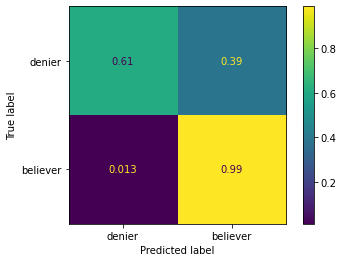

In [357]:
# visualize confusion matrix
con_mat = confusion_matrix(y_test, y_pred, normalize='true')
display = ConfusionMatrixDisplay(con_mat, display_labels=['denier', 'believer']).plot()


# Test on external dataset

A dataset from kaggle with labeled tweets as climate deniers or believers is imported for further validation of model

https://www.kaggle.com/edqian/twitter-climate-change-sentiment-dataset

In [335]:
val_df = pd.read_csv('data/twitter_sentiment_data.csv')

In [336]:
# re-map sentiment array to match existing model

cond_list = [val_df['sentiment'] == -1, 
             val_df['sentiment'] == 0,
             val_df['sentiment'] == 1,
             val_df['sentiment'] == 2]

choice_list = [0, None, val_df['sentiment'], None]

val_df['sentiment'] = np.select(cond_list, choice_list, 10)

In [337]:
# check for errors
val_df['sentiment'].value_counts()

1    22962
0     3990
Name: sentiment, dtype: int64

In [338]:
# check for matching tweets across datasets
count = 0
for id_ in val_df['tweetid']:
    if id_ in tweets['id']:
        count += 1
        print(id_)

In [339]:
# remove rows without usable ground truth
val_df_sub = val_df.dropna(subset = ['sentiment'])

# remove retweets
val_df_sub = val_df_sub[~val_df_sub['message'].str.startswith('RT ')]

In [348]:
# clean tweets
val_processed_text = val_df_sub['message'].apply(lambda x: clean_and_lem(x))

In [349]:
# make predictions on validation data
val_predict = gridsearch.predict(val_processed_text)
y = val_df_sub['sentiment'].astype(int)

Accuracy Score :      0.8287
Validation F1 Score : 0.8977


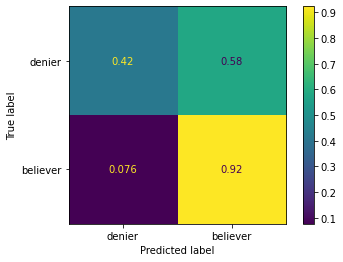

In [356]:
print(f"Accuracy Score :      {round(accuracy_score(y, val_predict), 4)}")
print(f"Validation F1 Score : {round(f1_score(y, val_predict), 4)}")

ConfusionMatrixDisplay(confusion_matrix(y, val_predict, normalize='true'), display_labels=['denier', 'believer']).plot();

## Apply Classifier to remainder dataset

Run the entire dataset through the gridsearch pipeline to make predictions on each tweet

In [343]:
# remove irrelevant response tweets
tweets_final = tweets[tweets['in_reply_to_screen_name'].isna()]

In [344]:
# prepare tweets for model
tweets_final['clean_text'] = tweets_final['full_text'].apply(lambda x: clean_and_lem(x)) 
tweets_final = tweets_final[tweets_final.clean_text.str.strip() != '']
tweets_final = tweets_final[tweets_final.clean_text.str.strip() != ' ']
# run text through model
tweets_final['believer_pred'] = gridsearch.predict(tweets_final['clean_text'])

/Users/browz/opt/anaconda3/envs/ds01/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [345]:
tweets_final['believer_pred'].value_counts(normalize=True)

1.0    0.941702
0.0    0.058298
Name: believer_pred, dtype: float64

In [346]:
# sanity check on predictions
def check_pred(df, n=None):
    if n == None:
        n = np.random.randint(0,len(df)-1)
    print(df.iloc[n]['full_text'], '\n', df.iloc[n]['believer_pred'])
    print(f'https://twitter.com/{df.iloc[n]["screen_names"]}/status/{df.iloc[n]["id"]}')

In [347]:
check_pred(tweets_final[tweets_final['believer_pred']==0])

Hilarious https://t.co/b1WsrQ7VxZ 
 0.0
https://twitter.com/Ilook4truth/status/1041446527036780544


# Sentiment Analysis

In [374]:
def sentiment_score(sentence): 
  
    # Instntiate SentimentIntensityAnalyzer object
    sid_obj = SentimentIntensityAnalyzer() 
  
    # store scoring data in dictionary  
    sentiment_dict = sid_obj.polarity_scores(sentence) 
    
    return sentiment_dict['compound']